# Grade Prediction

In [140]:
# Get dataset
import kagglehub
import os

path = kagglehub.dataset_download("samira1992/student-grades-intermediate-dataset")

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        path = os.path.join(dirname, filename)
# Print out dataset path
path

'/home/jm/.cache/kagglehub/datasets/samira1992/student-grades-intermediate-dataset/versions/1/Student_Grades.csv'

In [141]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
import torchvision.transforms.v2 as transforms

%matplotlib inline
# Use cuda if available
device = "cuda" if torch.cuda.is_available() else "cpu"
# Load dataframe
dataframe = pd.read_csv(path)

dataframe.head(5)

,Hours,Practice,TeamWork,MidTerm,FinalExam,Scores,Grade
0,2.5,0.5,0.0,2,2.3,21,C
1,5.1,1.5,0.5,4,4.9,47,B
2,3.2,1.0,0.5,3,2.9,27,C
3,8.5,3.7,1.2,7,7.7,75,A
4,3.5,1.2,0.3,3,3.2,30,C


In [142]:
# Convert pandas csv to dataset
class MyDataset(Dataset):
    def __init__(self, base_dataframe: pd.DataFrame):
        # Split features in dataset
        self.train_df = base_dataframe.drop(columns=["Scores", "Grade"]) # Feature set
        self.valid_df = base_dataframe[["Scores"]] # Data we are trying to predict
        
        # Convert dataframe values to float32 tensors and send them to GPU
        self.train_tensor = torch.tensor(self.train_df.values).float().to(device)
        self.valid_tensor = torch.tensor(self.valid_df.values).float().to(device)
        
    
    def __getitem__(self, index):
        x = self.train_tensor[index]
        y = self.valid_tensor[index]
        return x, y
    
    def __len__(self):
        return len(self.train_tensor)
        

In [143]:
# Create base model
base = torch.nn.Sequential(
    torch.nn.Linear(5, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1)
)
# Converts data to float32 tensor
preprocess_trans = transforms.Compose([
    transforms.ToDtype(torch.float32)
])
# Compile to gpu
model = torch.compile(base.to(device))

In [144]:
def train():
    batch_size = 16
    
    train_dataset = MyDataset(dataframe)
    train_loader = DataLoader(train_dataset, batch_size, True)
    
    valid_dataset = MyDataset(dataframe)
    valid_loader = DataLoader(valid_dataset, batch_size)
    
    loss_function = torch.nn.MSELoss()
    optimizer = Adam(base.parameters())
    
    training_epochLoss = []
    validate_epochLoss = []
    
    epochs = 128
    
    for epoch in range(epochs):
        step_loss = []
        valid_stepLoss = []
        
        model.train()
        for x, y in train_loader:
            # Feed forward
            output = model(x)
            # Clear gradients
            optimizer.zero_grad()
            # Calculate Loss
            train_loss = loss_function(output, y)
            # Calculate gradients
            train_loss.backward()
            # Update weights
            optimizer.step()
            # Collect train step loss
            step_loss.append(train_loss.item())
        # Collect train epoch loss
        training_epochLoss.append(np.array(step_loss).mean())
        
        model.eval()
        # Disable gradient calculation
        with torch.no_grad():
            for x, y in valid_loader:
                # Feed forward
                output = model(x)
                # Calculate loss
                valid_loss = loss_function(output, y)
                # Collect valid step loss
                valid_stepLoss.append(valid_loss.item())
                
        validate_epochLoss.append(np.array(valid_stepLoss).mean())
    
    plt.plot(training_epochLoss, label='train_loss')
    plt.plot(validate_epochLoss, label='valid_loss')
    plt.legend()
    plt.show()

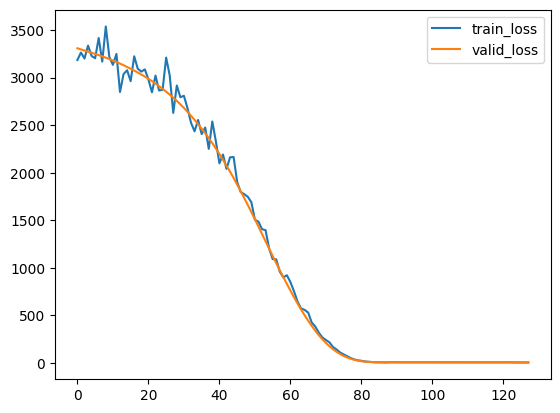

In [145]:
train()

In [ ]:
dataframe.head(3)

In [ ]:
# Test input
model(torch.tensor([[5, 1, 0.5, 4, 4.2,]], dtype=torch.float32).to(device))